In [58]:
#!/usr/bin/env python
"""
This Python code is based on Java code by Lee Jacobson found in an article
entitled "Applying a genetic algorithm to the travelling salesman problem"
that can be found at: http://www.theprojectspot.com/tutorial-post/applying-a-genetic-algorithm-to-the-travelling-salesman-problem/5
Converted to python by turbofart
https://gist.github.com/turbofart/3428880

I am going to change 
-the distance calculation function as we are limited on the number of cities we can visit during the day
-add estimated execution time
-add priorities
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
import random

plt.rcParams['figure.figsize'] = [20, 16]

Initial score: 1946.98897
Final score: 353.40583
Solution:


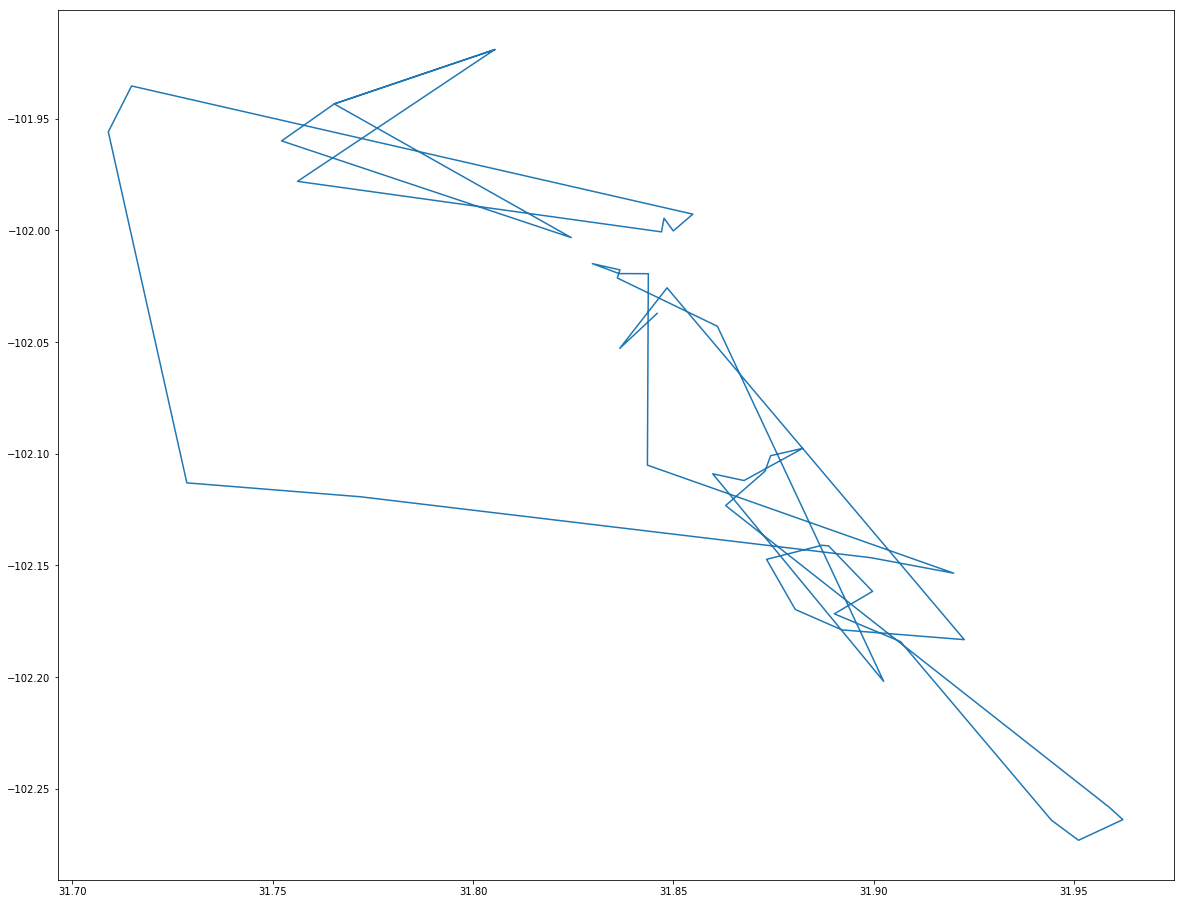

|--4--8--18--39--32--36--26--19--1--31--20--38--49--28--50--51--21--27--35--33--29--37--34--40--17--42--43--7--44--6--22--2--30--15--11--10--9--12--46--5--41--16--3--47--23--14--48--45--13--25
Wall time: 23min 39s


In [131]:
%%time

MUTATION_RATE = 0.015
TOURNAMENT_SIZE = 10
POPULATION_SIZE = 200
NUMBER_OF_ITERATIONS = 2000
TOTAL_WORK_DAY_MIN = 9*60
TOTAL_DAY_MIN = 24*60
WAREHOUSE_ID = 24

class City:
    def __init__(self, Id=0, x=None, y=None, priority=None, target_dt=None, est_exec_time=None):
        self.Id = 0
        self.Priority= 0
        ##meaning number of days from today
        self.Target_date= 0
        ## to clarify if the exec time can be more than 9 hrs
        self.Estimated_execution_time = 0
        self.timeToWarehouse = 0
        self.distanceToWarehouse = 0
        self.x = None
        self.y = None
        if Id is not None:
            self.Id = Id
            self.timeToWarehouse = Travel_times[(self.Id,WAREHOUSE_ID)]
            self.distanceToWarehouse = Travel_distances[(self.Id,WAREHOUSE_ID)]
        if priority is not None:
            self.Priority = random.randint(1,4)
            #self.Priority = priority
        if target_dt is not None:
            self.Target_date = random.randint(1,10)
            #self.Target_date = target_dt
        if est_exec_time is not None:
            self.Estimated_execution_time = random.randint(1,9)
            #self.Estimated_execution_time =est_exec_time
                    
        if x is not None:
            self.x = x
        if y is not None:
            self.y = y

    def getX(self):
        return self.x
   
    def getY(self):
        return self.y
   
    def distanceTo(self, city):
        ## in our case distance is pre-calculated and available from the Dict
        distance = Travel_distances[(self.Id, city.Id)]
        return distance

    def timeTo(self, city):
        time = Travel_times[(self.Id, city.Id)]
        return time
   
    def __repr__(self):
        return str(self.getX()) + ", " + str(self.getY())


class TourManager:
    destinationCities = []
   
    def addCity(self, city):
        self.destinationCities.append(city)
    
    def getCity(self, index):
        return self.destinationCities[index]
    
    def numberOfCities(self):
        return len(self.destinationCities)


class Tour:
    def __init__(self, tourmanager, tour=None):
        self.tourmanager = tourmanager
        self.tour = []
        self.fitness = 0.0
        self.priorities = 0
        self.time = 0
        if tour is not None:
            self.tour = tour
        else:
            for i in range(0, self.tourmanager.numberOfCities()):
                self.tour.append(None)
   
    def __len__(self):
        return len(self.tour)
   
    def __getitem__(self, index):
        return self.tour[index]
   
    def __setitem__(self, key, value):
        self.tour[key] = value

    def __repr__(self):
        geneString = "|"
        tour_x = []
        tour_y = []
        for i in range(0, self.tourSize()):
            city = self.getCity(i)
#             geneString += str(city) + "|" +str(city.Id)
            geneString += "--" +str(city.Id)
            tour_x.append(city.getX())
            tour_y.append(city.getY())
        fig = plt.figure()
        plt.plot(tour_x, tour_y)
        plt.show()
        return geneString

    def generateIndividual(self):
        for cityIndex in range(0, self.tourmanager.numberOfCities()):
            self.setCity(cityIndex, self.tourmanager.getCity(cityIndex))
        random.shuffle(self.tour)

    def getCity(self, tourPosition):
        return self.tour[tourPosition]

    def setCity(self, tourPosition, city):
        self.tour[tourPosition] = city
        self.fitness = 0.0
        self.distance = 0

    def getFitness(self):
        if self.fitness == 0:
            self.fitness = self.getScore()
        return self.fitness

    def getScore(self):
        ##correlation coeff ~0.87 and p-value = 0 indicates that time and distance are indeed correlated
        ##TODO: Thus, we will concentrate on Time only f(priority, time)
        if self.time == 0:
            #tourDistance = 0
            tourTime = 0
            tourPriorities = 0

            #Add distance, time from the warehouse to the first point 
            #tourDistance += self.getCity(0).distanceToWarehouse
            tourTime += self.getCity(0).timeToWarehouse

            _tourSize = self.tourSize()
            for cityIndex in range(0, _tourSize):
                fromCity = self.getCity(cityIndex)
                destinationCity = None
                if cityIndex+1 < _tourSize:
                    destinationCity = self.getCity(cityIndex+1)
                else:
                    destinationCity = self.getCity(0)
            
                #tripDistance = fromCity.distanceTo(destinationCity)
                tripTime = fromCity.timeTo(destinationCity)

                if tourTime + tripTime <= TOTAL_WORK_DAY_MIN:
                    #tourDistance += tripDistance
                    tourTime += tripTime + destinationCity.Estimated_execution_time
                else:
                    # if we can't complete the next WO today count as full day + time until the next morning
                    # so go back to warehouse, add time to come back to the field 
                    #tourDistance += fromCity.distanceToWarehouse + destinationCity.distanceToWarehouse 
                    tourTime = TOTAL_DAY_MIN + destinationCity.timeToWarehouse + destinationCity.Estimated_execution_time
                    #tourDistance += fromCity.timeToWarehouse + destinationCity.timeToWarehouse + destinationCity.Estimated_execution_time
                                        
            #Add distance from the last point to the warehouse 
            #tourDistance += self.getCity(_tourSize-1).distanceToWarehouse
            tourTime += self.getCity(_tourSize-1).timeToWarehouse
            
            #self.distance = tourDistance
            self.time = tourTime
            
        return self.time

    def tourSize(self):
        return len(self.tour)

    def containsCity(self, city):
        return city in self.tour


class Population:
    def __init__(self, tourmanager, populationSize, initialise):
        self.tours = []
        for i in range(0, populationSize):
            self.tours.append(None)

        if initialise:
            for i in range(0, populationSize):
                newTour = Tour(tourmanager)
                newTour.generateIndividual()
                self.saveTour(i, newTour)

    def __setitem__(self, key, value):
        self.tours[key] = value

    def __getitem__(self, index):
        return self.tours[index]

    def saveTour(self, index, tour):
        self.tours[index] = tour

    def getTour(self, index):
        return self.tours[index]

    def getFittest(self):
        fittest = self.tours[0]
        for i in range(0, self.populationSize()):
            if fittest.getFitness() >= self.getTour(i).getFitness():
                fittest = self.getTour(i)
        return fittest

    def populationSize(self):
        return len(self.tours)


class GA:
    def __init__(self, tourmanager):
        self.tourmanager = tourmanager
        self.mutationRate = MUTATION_RATE
        self.tournamentSize = TOURNAMENT_SIZE
        self.elitism = True

    def evolvePopulation(self, pop):
        newPopulation = Population(self.tourmanager, pop.populationSize(), False)
        elitismOffset = 0
        if self.elitism:
            newPopulation.saveTour(0, pop.getFittest())
            elitismOffset = 1

        for i in range(elitismOffset, newPopulation.populationSize()):
#             while (True):
            ## choose random 5 from the population and find the fittest among them
            parent1 = self.tournamentSelection(pop)
            ## again choose random 5 from the population and find the fittest among them
            parent2 = self.tournamentSelection(pop)
            ##TODO: how do you make sure parent1 != parent2?
#                 if (parent1 != parent2):
            child = self.crossover(parent1, parent2)
            newPopulation.saveTour(i, child)
#                     break

        for i in range(elitismOffset, newPopulation.populationSize()):
            self.mutate(newPopulation.getTour(i))

        return newPopulation

    def crossover(self, parent1, parent2):
        child = Tour(self.tourmanager)

        startPos = int(random.random() * parent1.tourSize())
        endPos = int(random.random() * parent1.tourSize())

        for i in range(0, child.tourSize()):
            if startPos < endPos and i > startPos and i < endPos:
                child.setCity(i, parent1.getCity(i))
            elif startPos > endPos:
                if not (i < startPos and i > endPos):
                    child.setCity(i, parent1.getCity(i))

        for i in range(0, parent2.tourSize()):
            if not child.containsCity(parent2.getCity(i)):
                for ii in range(0, child.tourSize()):
                    if child.getCity(ii) == None:
                        child.setCity(ii, parent2.getCity(i))
                        break

        return child

    def mutate(self, tour):
        ###TODO: review mutation
        for tourPos1 in range(0, tour.tourSize()):
            if random.random() < self.mutationRate:
                tourPos2 = int(tour.tourSize() * random.random())

                city1 = tour.getCity(tourPos1)
                city2 = tour.getCity(tourPos2)

                tour.setCity(tourPos2, city1)
                tour.setCity(tourPos1, city2)

    def tournamentSelection(self, pop):
        tournament = Population(self.tourmanager, self.tournamentSize, False)
        for i in range(0, self.tournamentSize):
            randomId = int(random.random() * pop.populationSize())
            tournament.saveTour(i, pop.getTour(randomId))
        fittest = tournament.getFittest()
        return fittest

if __name__ == '__main__':
    tourmanager = TourManager()

    # Create and add our cities
    cities = df[['Origin OID','Latitude','Longitude']].groupby(['Origin OID']).min()

    ##TODO: for the purpose of this example let's make the point 24 (31.8134,-101.894) the warehouse 
    for index, row in cities.iterrows():
        city = City(index,row.Latitude, row.Longitude)
        if index == WAREHOUSE_ID:
            continue
        tourmanager.addCity(city)

    # Initialize population
    pop = Population(tourmanager, POPULATION_SIZE, True);
    print "Initial score: " + str(pop.getFittest().getScore())

    # Evolve population for 50 generations
    ga = GA(tourmanager)
    pop = ga.evolvePopulation(pop)
    for i in range(0, NUMBER_OF_ITERATIONS):
        pop = ga.evolvePopulation(pop)

    # Print final results
    print "Final score: " + str(pop.getFittest().getScore())
#     print "Final time: " + str(pop.getFittest().getTime())
#     print "Final distance: " + str(pop.getFittest().getDistance())

    print "Solution:"
    print pop.getFittest()

Final distance: 1468.3927234


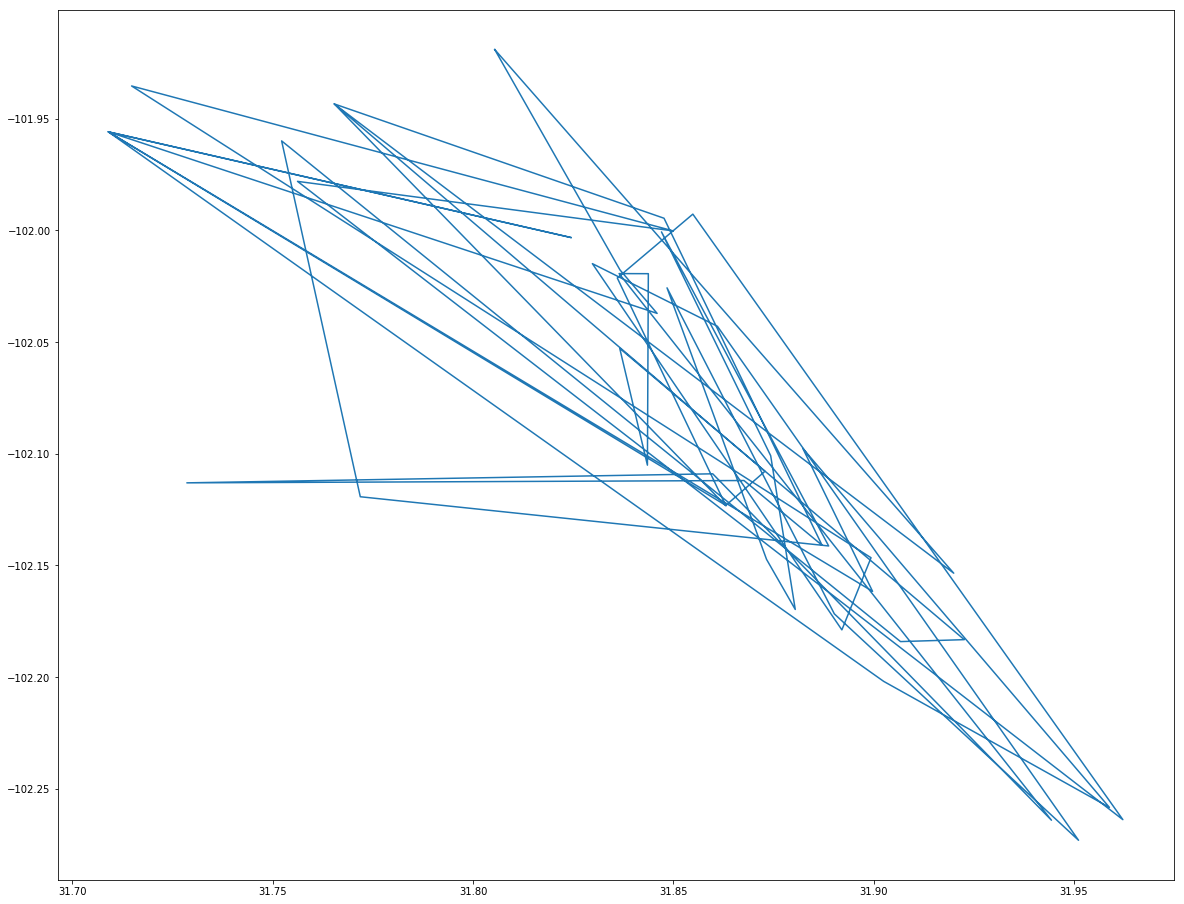

|--25--2--13--16--19--37--11--34--49--44--6--22--8--39--38--48--15--1--3--33--36--26--18--20--28--17--7--32--30--46--41--47--50--5--42--21--14--35--27--10--45--12--31--29--51--40--9--4--43--23


In [128]:
# MUTATION_RATE = 0.025
# TOURNAMENT_SIZE = 30
# POPULATION_SIZE = 1000
# NUMBER_OF_ITERATIONS = 10000
#time 9h 19m 52s
print "Final distance: " + str(pop.getFittest().getDistance())
print pop.getFittest()


Final distance: 1467.3927234


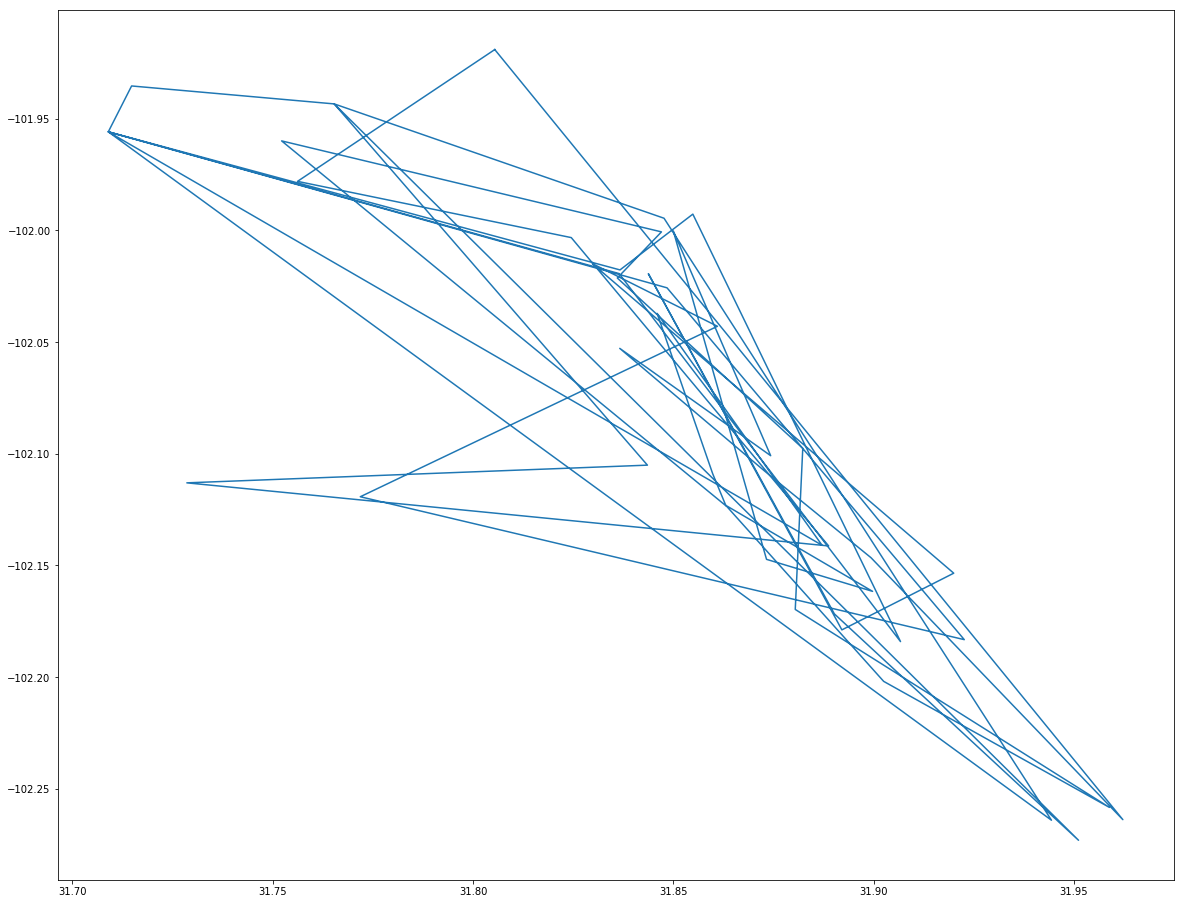

|--25--47--45--1--11--22--13--46--10--44--38--5--43--12--49--16--14--28--20--6--32--2--7--17--15--39--18--9--19--4--34--21--48--3--42--29--36--51--40--27--31--26--37--41--33--8--35--30--50--23


In [126]:
# #with going back to Warehouse
# MUTATION_RATE = 0.015
# TOURNAMENT_SIZE = 30
# POPULATION_SIZE = 100
# NUMBER_OF_ITERATIONS = 2500
#time 14m 11
print "Final distance: " + str(pop.getFittest().getDistance())
print pop.getFittest()

Final distance: 1471.3927234


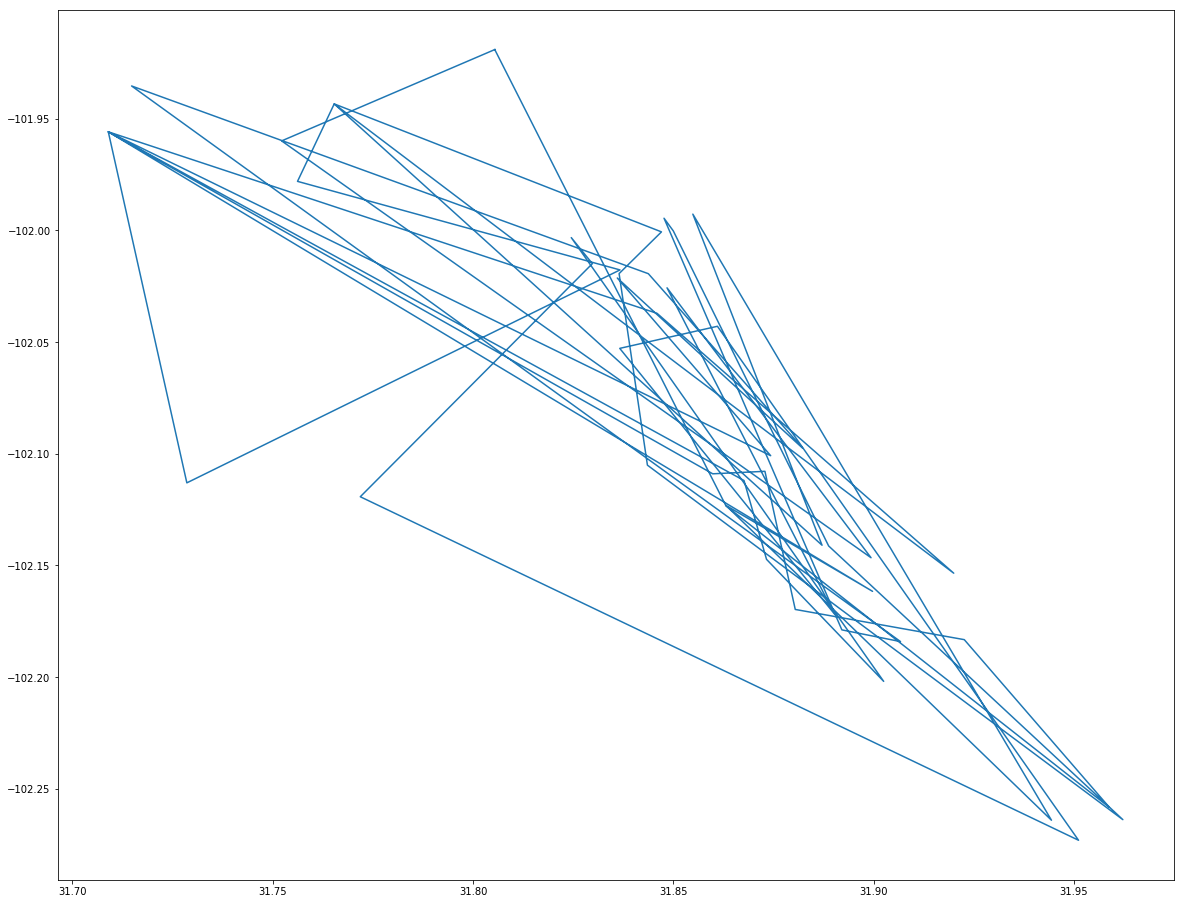

|--23--21--51--39--36--35--34--9--4--2--13--3--44--22--50--1--41--16--32--38--46--6--29--42--33--10--31--27--49--5--19--14--47--43--11--12--37--26--40--45--7--15--28--17--8--20--18--30--48--25


In [122]:
#with going back to Warehouse
# MUTATION_RATE = 0.015
# TOURNAMENT_SIZE = 30
# POPULATION_SIZE = 100
# NUMBER_OF_ITERATIONS = 2500
#time 14m 35
print "Final distance: " + str(pop.getFittest().getDistance())
print pop.getFittest()

Final distance: 1468.3927234


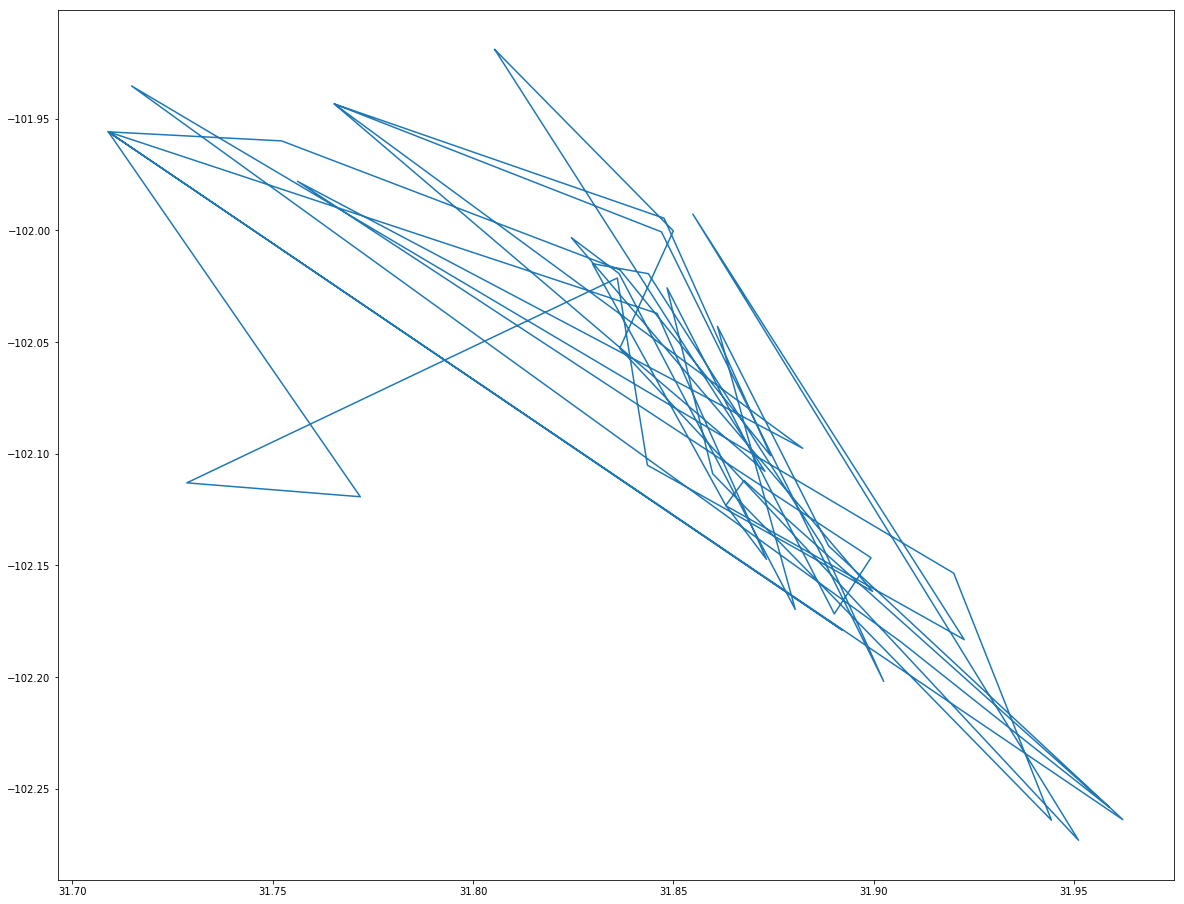

|--23--35--13--16--33--43--48--10--50--1--17--36--44--45--31--22--42--11--15--12--32--9--4--26--27--37--51--38--46--2--49--34--18--20--30--47--29--14--3--40--19--6--7--21--39--5--28--8--41--25


In [120]:
#with going back to Warehouse
# MUTATION_RATE = 0.015
# TOURNAMENT_SIZE = 30
# POPULATION_SIZE = 200
# NUMBER_OF_ITERATIONS = 2500
#time 28m 35
print "Final distance: " + str(pop.getFittest().getDistance())
print pop.getFittest()

Final distance: 240.08575


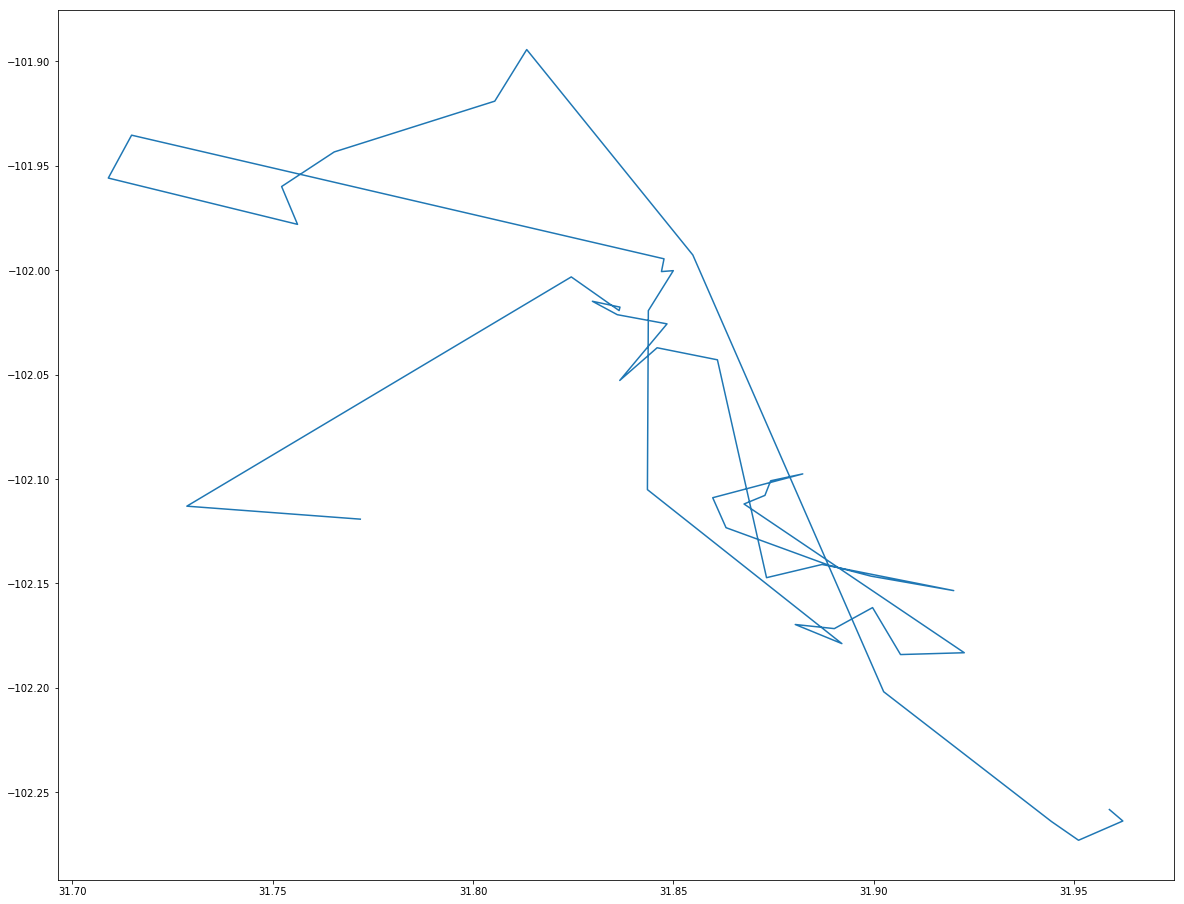

|--15--11--45--44--43--7--42--18--8--4--17--26--19--2--30--1--21--27--34--29--33--35--37--39--38--31--20--36--32--22--6--41--3--16--46--12--9--10--47--48--14--13--23--25--24--5--40--49--28--50--51


In [112]:
# MUTATION_RATE = 0.015
# TOURNAMENT_SIZE = 15
# POPULATION_SIZE = 100
# NUMBER_OF_ITERATIONS = 10000
#time 1h 7min 48
print "Final distance: " + str(pop.getFittest().getDistance())
print pop.getFittest()

Final distance: 279.39201


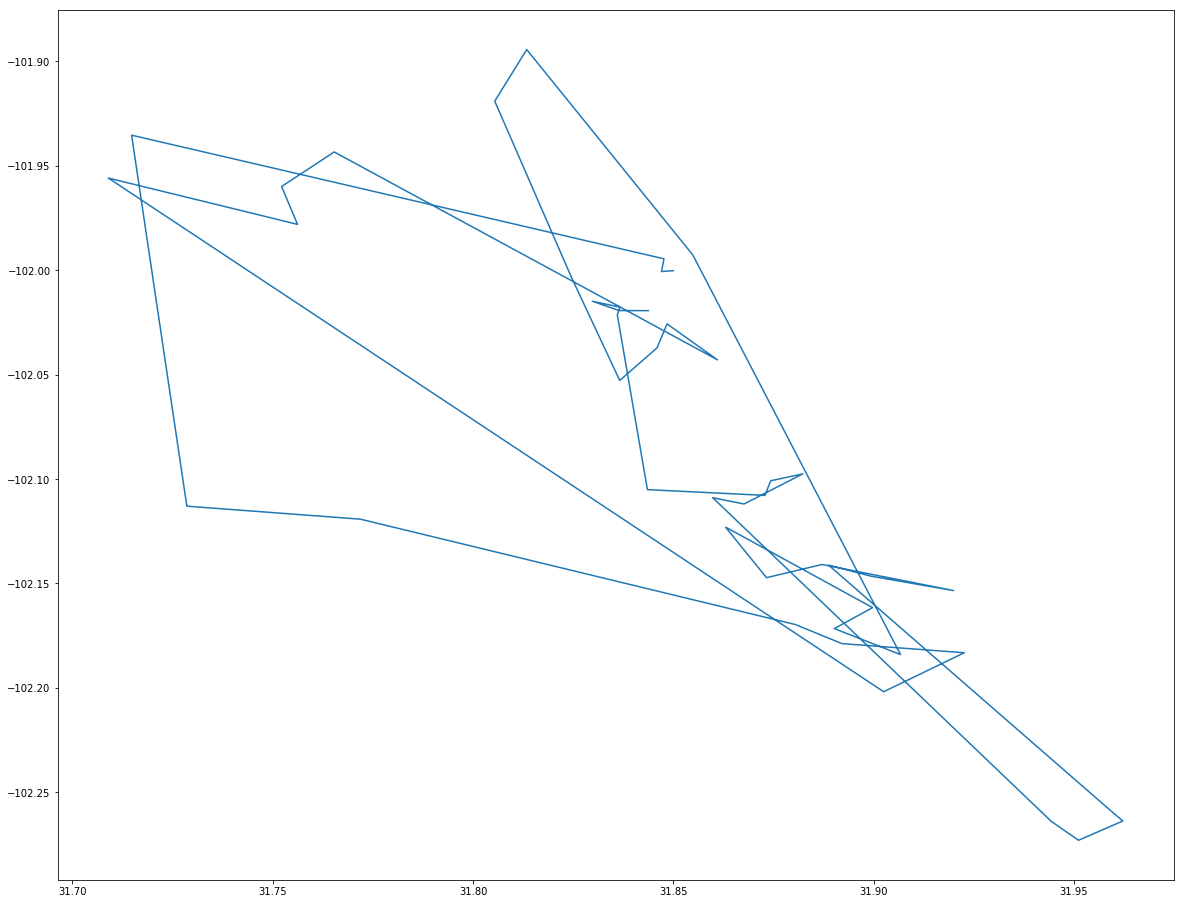

|--6--44--7--43--42--22--35--33--29--37--34--49--28--50--51--1--30--2--19--26--21--27--31--20--38--5--24--23--25--45--8--4--18--17--14--13--48--47--9--10--12--40--39--32--36--15--11--46--16--3--41


In [110]:
# MUTATION_RATE = 0.015
# TOURNAMENT_SIZE = 15
# POPULATION_SIZE = 100
# NUMBER_OF_ITERATIONS = 2500
#time 15min 36
print "Final distance: " + str(pop.getFittest().getDistance())
print pop.getFittest()

Final distance: 290.10065


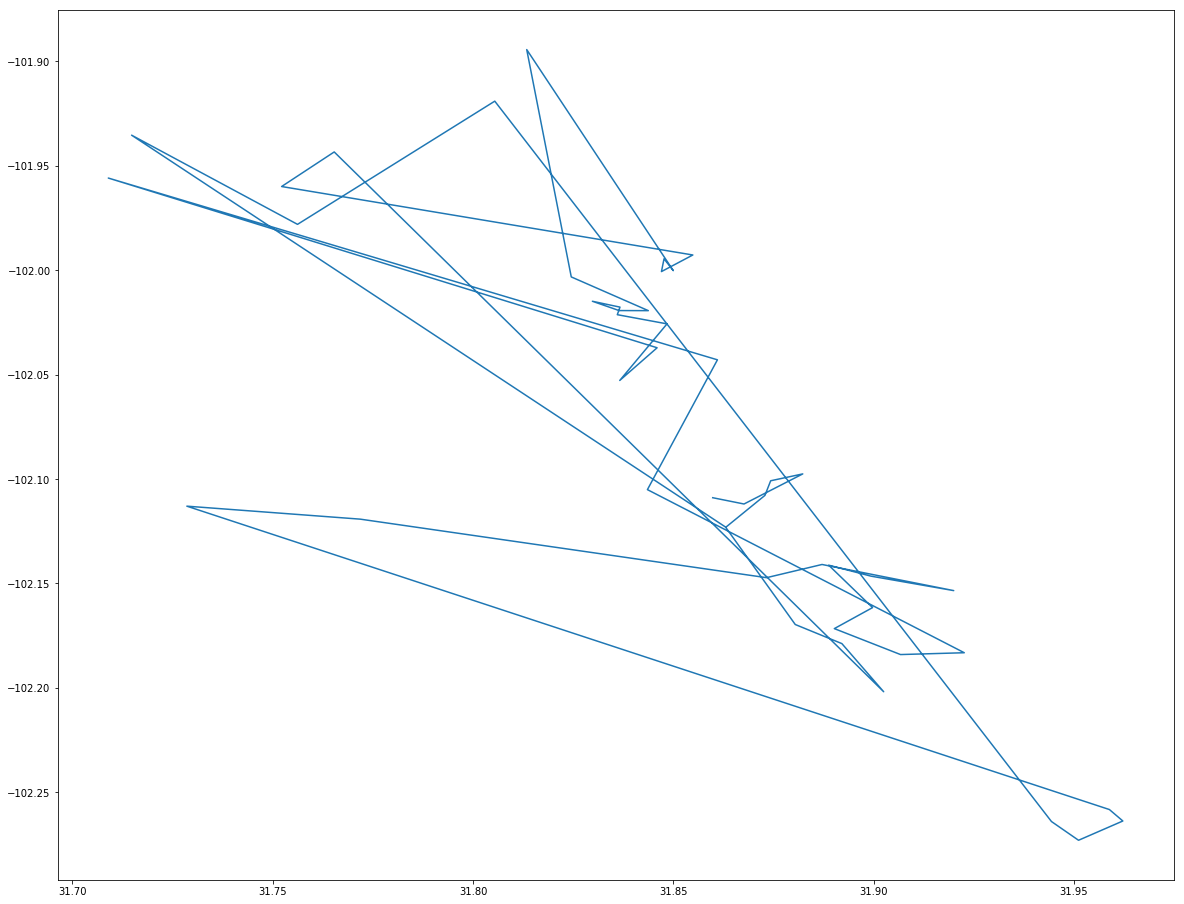

|--21--36--32--40--14--13--48--5--3--16--41--24--45--6--44--7--43--42--18--8--4--10--12--9--17--22--39--38--20--31--1--30--2--19--26--15--11--51--50--28--49--25--23--47--46--27--35--33--29--37--34


In [108]:
# MUTATION_RATE = 0.015
# TOURNAMENT_SIZE = 5
# POPULATION_SIZE = 50
# NUMBER_OF_ITERATIONS = 2000
#time 5min 49s
print "Final distance: " + str(pop.getFittest().getDistance())
print pop.getFittest()

Final distance: 1.81697188982


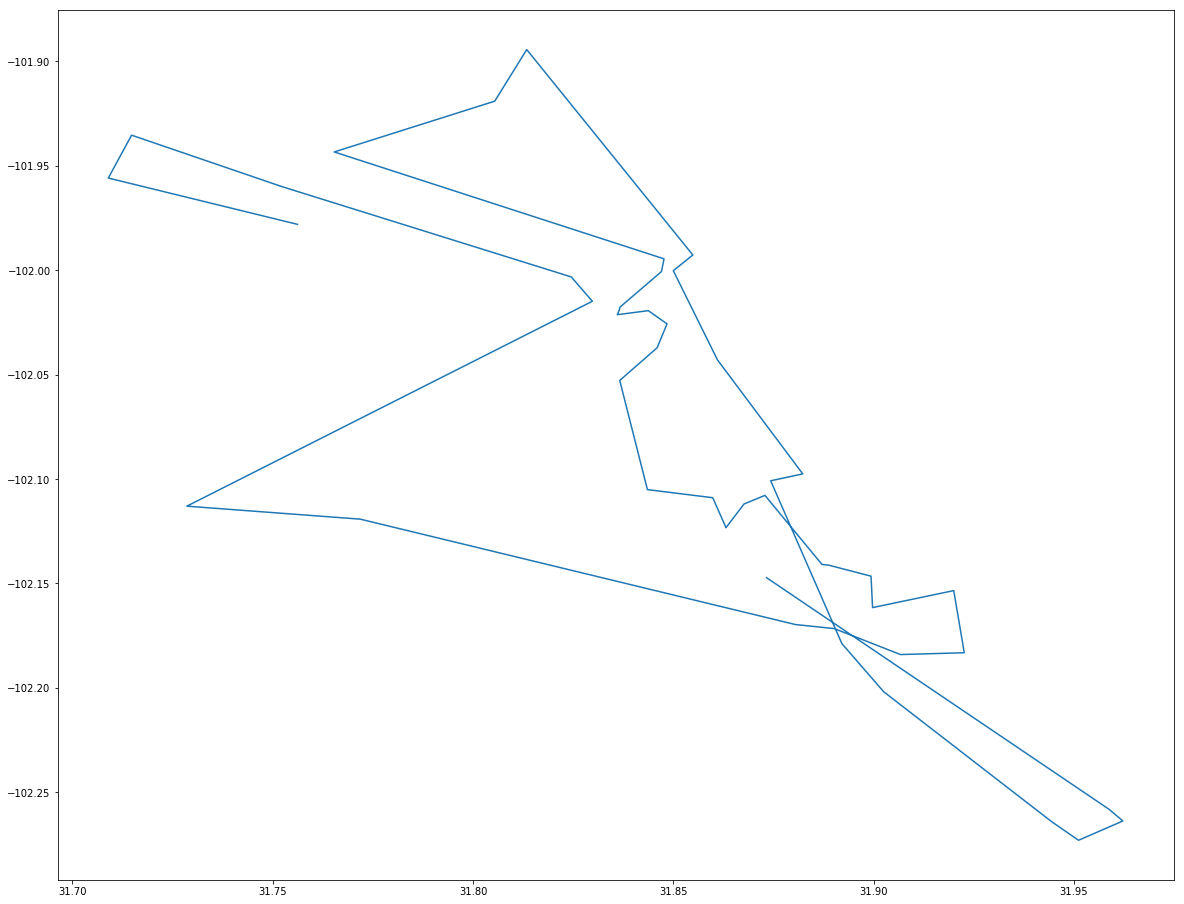

|31.87329, -102.147315|31.958896, -102.258399|31.962252, -102.263882|31.951189, -102.273116|31.94443, -102.26414|31.902537, -102.201957|31.8921, -102.1789|31.874323, -102.100891|31.882336, -102.097598|31.861028, -102.042944|31.850011, -102.000231|31.854889, -101.992722|31.813414, -101.894312|31.805436, -101.919025|31.805436, -101.919025|31.76535, -101.943356|31.76535, -101.943356|31.847694, -101.994556|31.847056, -102.000667|31.8367, -102.0177|31.836478, -102.019347|31.83603, -102.021322|31.843778, -102.019389|31.848444, -102.025722|31.845972, -102.037167|31.836639, -102.052833|31.84355, -102.105131|31.859854, -102.109007|31.863125, -102.123149|31.863159, -102.123352|31.867667, -102.112017|31.87289, -102.107891|31.887147, -102.140992|31.888797, -102.141314|31.899379, -102.146588|31.899764, -102.16165|31.920028, -102.153511|31.922661, -102.183274|31.906742, -102.184145|31.890215, -102.171717|31.880461, -102.169751|31.771861, -102.119278|31.728556, -102.113056|31.829806, -102.014889|31.8

In [65]:
#population size 2000, exec time 7 min 15 s
print "Final distance: " + str(pop.getFittest().getDistance())
print pop.getFittest()

Final distance: 1.56839624035


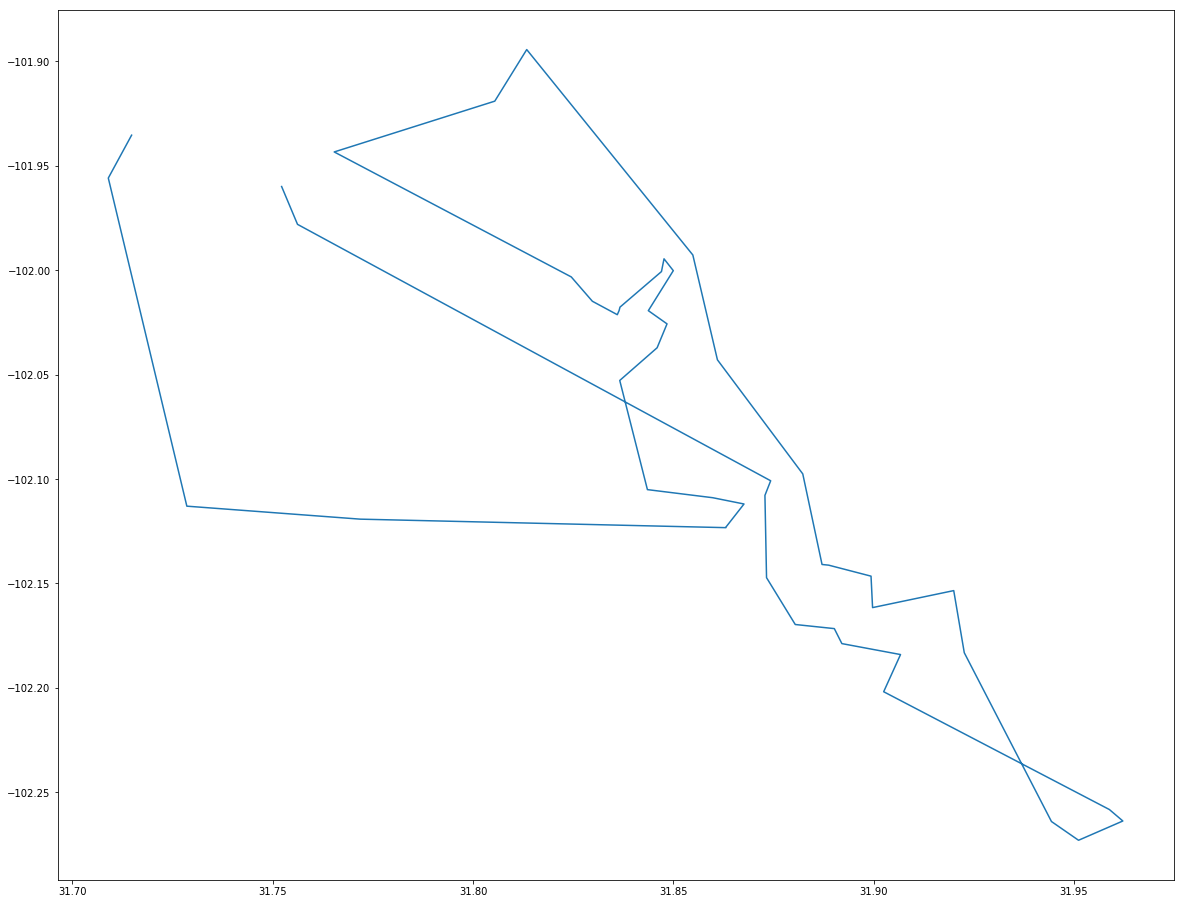

|31.752219, -101.959921|31.756188, -101.978045|31.874323, -102.100891|31.87289, -102.107891|31.87329, -102.147315|31.880461, -102.169751|31.890215, -102.171717|31.8921, -102.1789|31.906742, -102.184145|31.902537, -102.201957|31.958896, -102.258399|31.962252, -102.263882|31.951189, -102.273116|31.94443, -102.26414|31.922661, -102.183274|31.920028, -102.153511|31.899764, -102.16165|31.899379, -102.146588|31.888797, -102.141314|31.887147, -102.140992|31.882336, -102.097598|31.861028, -102.042944|31.854889, -101.992722|31.813414, -101.894312|31.805436, -101.919025|31.805436, -101.919025|31.76535, -101.943356|31.76535, -101.943356|31.824536, -102.003229|31.829806, -102.014889|31.83603, -102.021322|31.836478, -102.019347|31.8367, -102.0177|31.847056, -102.000667|31.847694, -101.994556|31.850011, -102.000231|31.843778, -102.019389|31.848444, -102.025722|31.845972, -102.037167|31.836639, -102.052833|31.84355, -102.105131|31.859854, -102.109007|31.867667, -102.112017|31.863125, -102.123149|31.8

In [63]:
#population size 1500, exec time 6 min
print "Final distance: " + str(pop.getFittest().getDistance())
print pop.getFittest()

Final distance: 1.7274672551


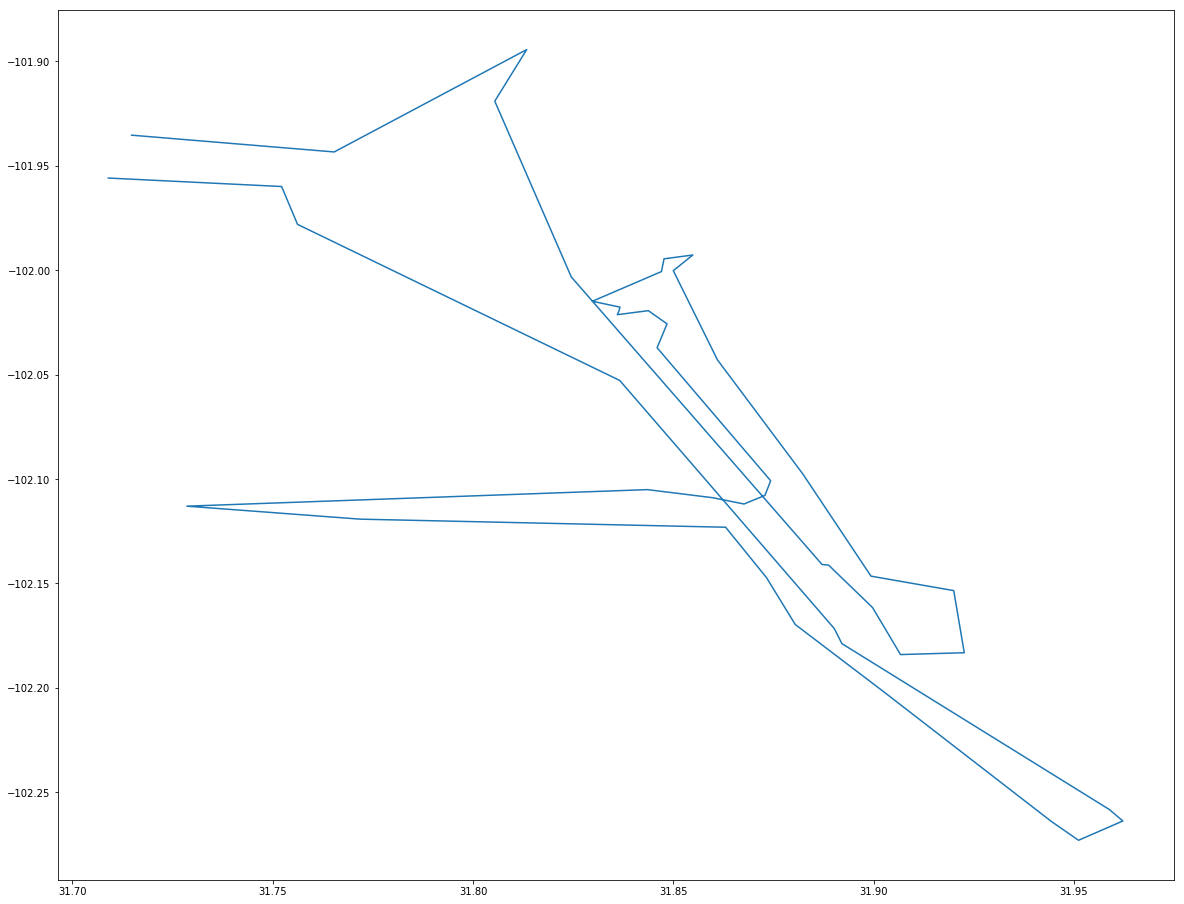

|31.708945, -101.955861|31.708945, -101.955861|31.708945, -101.955861|31.752219, -101.959921|31.756188, -101.978045|31.836639, -102.052833|31.890215, -102.171717|31.8921, -102.1789|31.958896, -102.258399|31.962252, -102.263882|31.951189, -102.273116|31.94443, -102.26414|31.902537, -102.201957|31.880461, -102.169751|31.87329, -102.147315|31.863159, -102.123352|31.863125, -102.123149|31.771861, -102.119278|31.728556, -102.113056|31.84355, -102.105131|31.859854, -102.109007|31.867667, -102.112017|31.87289, -102.107891|31.874323, -102.100891|31.845972, -102.037167|31.848444, -102.025722|31.843778, -102.019389|31.83603, -102.021322|31.836478, -102.019347|31.8367, -102.0177|31.829806, -102.014889|31.847056, -102.000667|31.847694, -101.994556|31.854889, -101.992722|31.850011, -102.000231|31.861028, -102.042944|31.882336, -102.097598|31.899379, -102.146588|31.920028, -102.153511|31.922661, -102.183274|31.906742, -102.184145|31.899764, -102.16165|31.888797, -102.141314|31.887147, -102.140992|31

In [61]:
#population size 1000
print "Final distance: " + str(pop.getFittest().getDistance())
print pop.getFittest()

In [102]:
Travel_distances = {}
Travel_times = {}
for index, row in df.iterrows():
    Travel_distances[(row['Destination_OID'],row['Origin OID'])] = row['Total Distance (Miles)']
    Travel_distances[(row['Origin OID'],row['Destination_OID'])] = row['Total Distance (Miles)']
    
    Travel_times[(row['Destination_OID'],row['Origin OID'])] = row['Total Time (Minutes)']
    Travel_times[(row['Origin OID'],row['Destination_OID'])] = row['Total Time (Minutes)']
    

In [68]:
df.columns

Index([u'Destination Rank', u'Total Time (Minutes)', u'Total Distance (Miles)',
       u'Origin OID', u'Shape_Length', u'Area', u'Equipment_Code', u'Class',
       u'Class_Description', u'Equipment_Description', u'Parent_Code',
       u'FieldOperationsTeam', u'FieldProductionTeam', u'Cost_Code',
       u'CommissionDate', u'Latitude', u'Longitude', u'Destination_OID',
       u'Equipment_Code.1', u'Class.1', u'Class_Description.1',
       u'Equipment_Description.1', u'Parent_Code.1', u'FieldOperationsTeam.1',
       u'FieldProductionTeam.1', u'Cost_Code.1', u'CommissionDate.1',
       u'Latitude.1', u'Longitude.1'],
      dtype='object')

Text(31.8888,-102.141,u'1')

Text(31.92,-102.154,u'2')

Text(31.8471,-102.001,u'3')

Text(31.846,-102.037,u'4')

Text(31.8549,-101.993,u'5')

Text(31.8438,-102.019,u'6')

Text(31.8298,-102.015,u'7')

Text(31.8366,-102.053,u'8')

Text(31.7089,-101.956,u'9')

Text(31.7089,-101.956,u'10')

Text(31.7286,-102.113,u'11')

Text(31.7089,-101.956,u'12')

Text(31.7654,-101.943,u'13')

Text(31.7654,-101.943,u'14')

Text(31.7719,-102.119,u'15')

Text(31.8477,-101.995,u'16')

Text(31.861,-102.043,u'17')

Text(31.8484,-102.026,u'18')

Text(31.8871,-102.141,u'19')

Text(31.8902,-102.172,u'20')

Text(31.8632,-102.123,u'21')

Text(31.8436,-102.105,u'22')

Text(31.8054,-101.919,u'23')

Text(31.8134,-101.894,u'24')

Text(31.8054,-101.919,u'25')

Text(31.8733,-102.147,u'26')

Text(31.8631,-102.123,u'27')

Text(31.9512,-102.273,u'28')

Text(31.8823,-102.098,u'29')

Text(31.8994,-102.147,u'30')

Text(31.8998,-102.162,u'31')

Text(31.8921,-102.179,u'32')

Text(31.8743,-102.101,u'33')

Text(31.8599,-102.109,u'34')

Text(31.8729,-102.108,u'35')

Text(31.8805,-102.17,u'36')

Text(31.8677,-102.112,u'37')

Text(31.9067,-102.184,u'38')

Text(31.9227,-102.183,u'39')

Text(31.9025,-102.202,u'40')

Text(31.85,-102,u'41')

Text(31.836,-102.021,u'42')

Text(31.8367,-102.018,u'43')

Text(31.8365,-102.019,u'44')

Text(31.8245,-102.003,u'45')

Text(31.7148,-101.935,u'46')

Text(31.7562,-101.978,u'47')

Text(31.7522,-101.96,u'48')

Text(31.9444,-102.264,u'49')

Text(31.9623,-102.264,u'50')

Text(31.9589,-102.258,u'51')

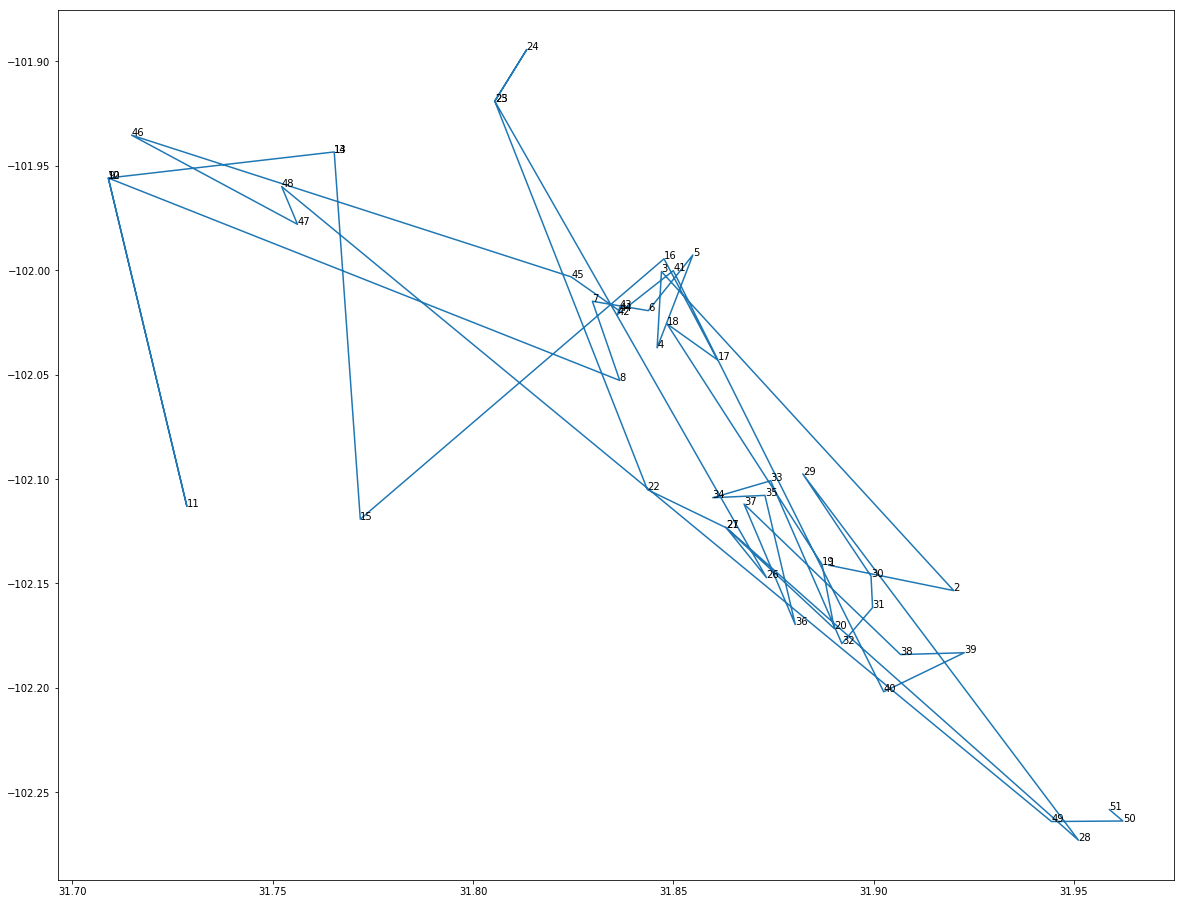

In [115]:
### Seeing City(WO) locations
tmp = df[['Origin OID','Latitude','Longitude']].groupby(['Origin OID']).min()
tour_x = []
tour_y = []
for index, row in tmp.iterrows():
    tour_x.append(row.Latitude)
    tour_y.append(row.Longitude)
    plt.text(row.Latitude, row.Longitude, index);
tour_x = np.array(tour_x)
tour_y = np.array(tour_y)

plt.plot(tour_x, tour_y)
plt.show()

(0.86573122358202814, 0.0)

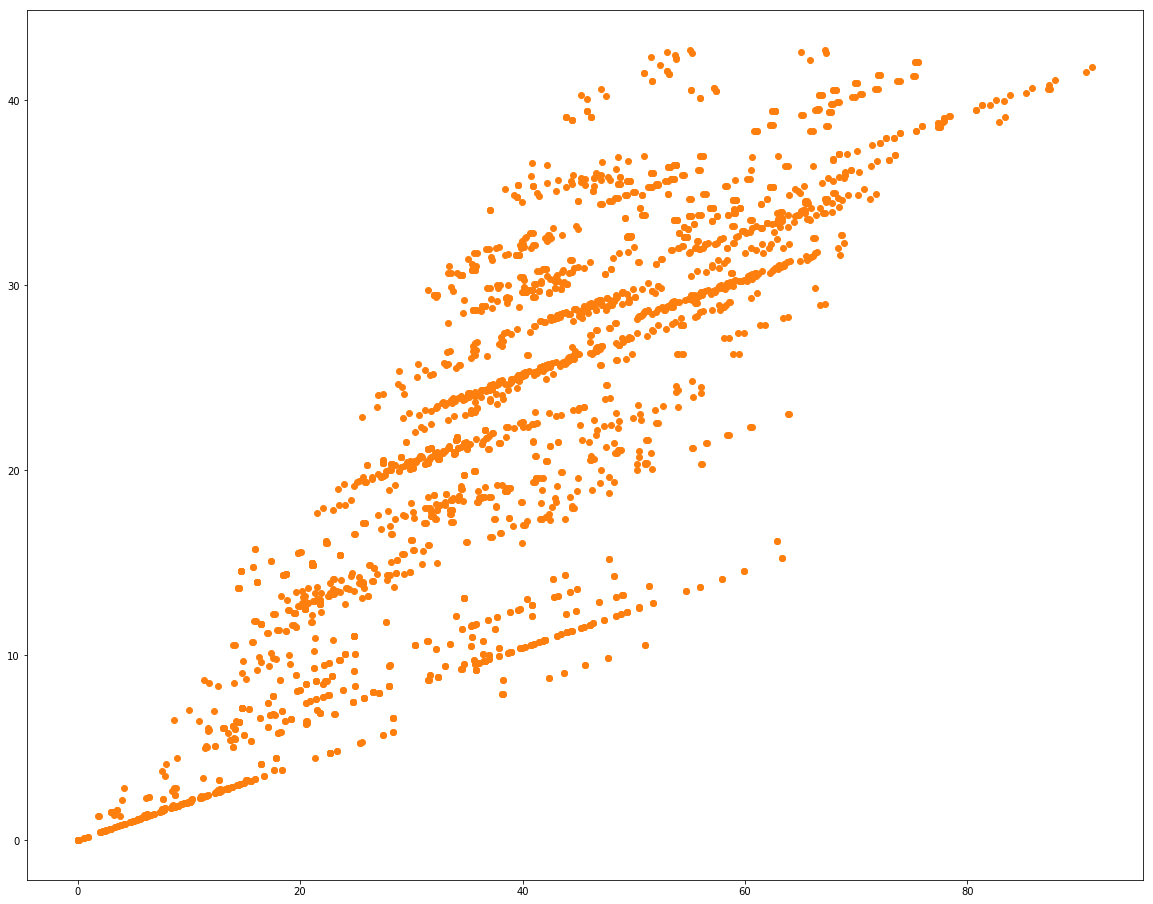

In [136]:
from scipy.stats import pearsonr

pearsonr(df['Total Time (Minutes)'],df['Total Distance (Miles)'])
plt.scatter(df['Total Time (Minutes)'],df['Total Distance (Miles)'])
plt.show()

## this result of correlation coeff ~0.87 and p-value = 0 indicates that time and distance are indeed correlated